# Models from scratch

We are gonna run our scratch models here, hypertune them, evaluate them and save the models.

In [1]:
# importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os 
import joblib

from sklearn.model_selection import RandomizedSearchCV   

# importing custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.data.load_data import load_data

from src.models.MLP_scratch import MLP as MLP_scratch, Trainer as Trainer_scratch
from src.models.DT_scratch import Decision_tree as DT_scratch
from src.utils.tuning import run_random_search
# from src.utils.optimiziers import Adam, SGD, SGDMomentum, Adagrad
# from src.utils.losses import MAE, MSE, Huber, LogCosh
from src.visualization.model_plots import prediction_distribution, parity_plot, residual_plot,  plot_learning_curve




Loading in the `X` features and the specified `y` targets

In [2]:
target = "log_ClaimRate"

(X_train, y_train), (X_test, y_test)= load_data(raw=False, target=target)

## Decision Tree from Scratch

In [4]:
DT = DT_scratch(
    max_depth=5,
    min_samples_split=10,
)


In [5]:
param_grid = {
    "max_depth": [None, 2, 3, 5, 8, 12],
    "min_samples_split": [2, 5, 10, 20, 50]
}


In [6]:
search = run_random_search(DT, param_grid, X_train, y_train, n_iter=50)

/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

In [7]:
DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)
mse = np.mean((y_test - y_pred)**2)
print(f"Test MSE: {mse}")


Test MSE: 0.10623657589302507


In [ ]:
residual_plot(y_test, y_pred, title="Decision Tree Residual Plot")

## Neural Network from Scratch

We make an instance of our Neural Network class.

In [4]:
MLP = Trainer_scratch(input_dim=X_train.shape[1], 
                      hidden_sizes=[32, 64],
                      model=MLP_scratch,
                      optimizer="adam",
                      loss_fn="mse",
                      epochs=100
                      )

we also need to define our parameter distributions for RandomizedGridSearchCV.

In [5]:
param_dist_MLP = {
    "hidden_sizes": [
        [32, 64], 
        [64, 128], 
        [128, 256],
        [32, 64, 128],
        [64, 128, 256],
        [8, 16, 32, 64],
        [16, 32, 64, 128],
    ],
    "optimizer": ["sgd", "sgd_momentum", "adam", "adagrad"],
    "loss_fn": ["mse", "mae", "huber", "logcosh"],
    "batch_size": [32, 64, 128, 256],
}


And we run the hyperparameter tuning model using Randomized Search, and RMSE as the evaluation metric for 25 iterations.

In [6]:
search = run_random_search(MLP, param_dist_MLP, X_train, y_train, n_iter=25, n_jobs=-1)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Epoch   1 | train_loss=0.111039
Epoch   2 | train_loss=0.102760
Epoch   3 | train_loss=0.101702
Epoch   4 | train_loss=0.101213
Epoch   5 | train_loss=0.100929
Epoch   6 | train_loss=0.100745
Epoch   7 | train_loss=0.100618
Epoch   8 | train_loss=0.100525
Epoch   9 | train_loss=0.100455
Epoch  10 | train_loss=0.100401
Epoch  11 | train_loss=0.100356
Epoch  12 | train_loss=0.100320
Epoch  13 | train_loss=0.100289
Epoch  14 | train_loss=0.100262
Epoch  15 | train_loss=0.100238
Epoch  16 | train_loss=0.100217
Epoch  17 | train_loss=0.100198
Epoch  18 | train_loss=0.100180
Epoch  19 | train_loss=0.100163
Epoch  20 | train_loss=0.100147
Epoch  21 | train_loss=0.100133
Epoch  22 | train_loss=0.100119
Epoch  23 | train_loss=0.100105
Epoch  24 | train_loss=0.100092
Epoch  25 | train_loss=0.100080
Epoch  26 | train_loss=0.100068
Epoch  27 | train_loss=0.100056
Epoch  28 | train_loss=0.100045
Epoch  29 | train_loss=0.100034
Epoch  30 

We have to choose the best model from this.

In [8]:
best_model = search.best_estimator_


In [10]:
best_model.get_params()

{'input_dim': 35,
 'hidden_sizes': [128, 256],
 'batch_size': 256,
 'epochs': 100,
 'shuffle': True,
 'loss_fn': 'mse',
 'optimizer': 'sgd_momentum'}

Let's see how it did:

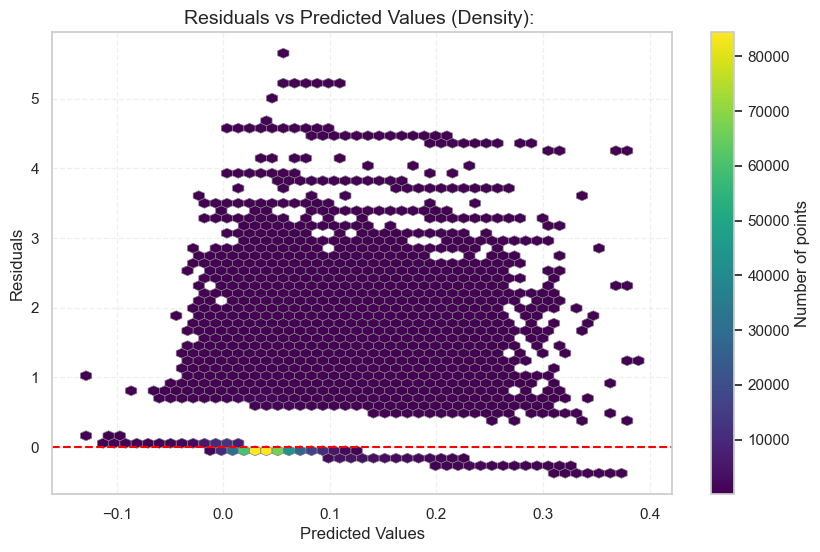

In [11]:
y_train_pred = best_model.predict(X_train)
residual_plot(y_true=y_train, y_pred=y_train_pred)

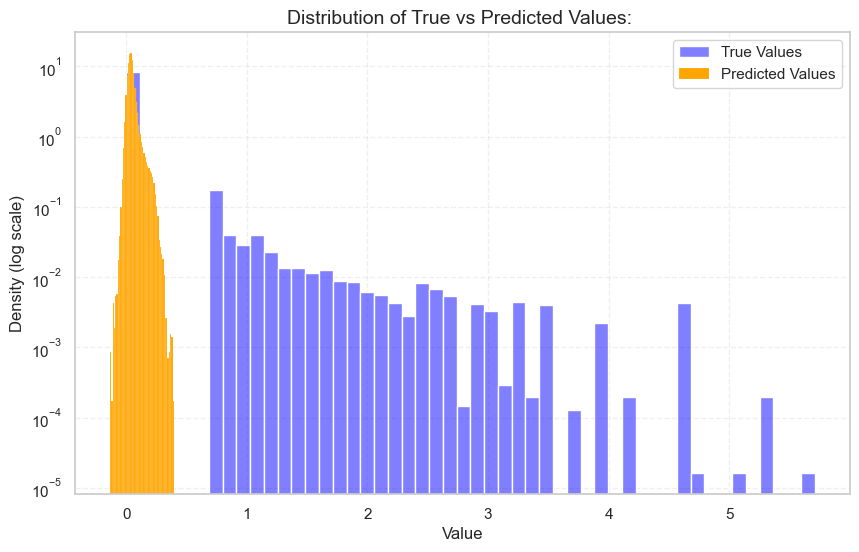

In [12]:
prediction_distribution(y_true=y_train, y_pred=y_train_pred)

d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


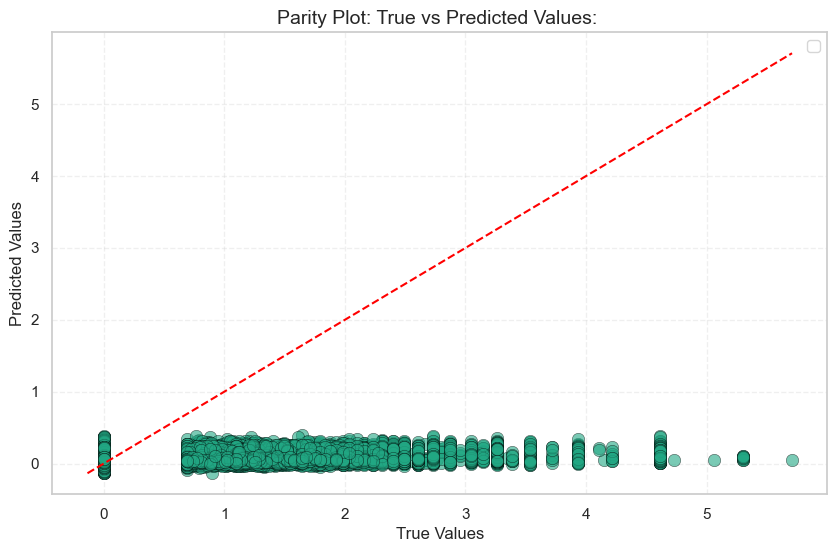

In [13]:
parity_plot(y_pred=y_train_pred, y_true=y_train)

In [14]:
plot_learning_curve(best_model, X_train, y_train)

KeyboardInterrupt: 

### Evaluation 

Let's use our model on the test data.

In [15]:
y_test_pred = best_model.predict(X_test)

Plots:


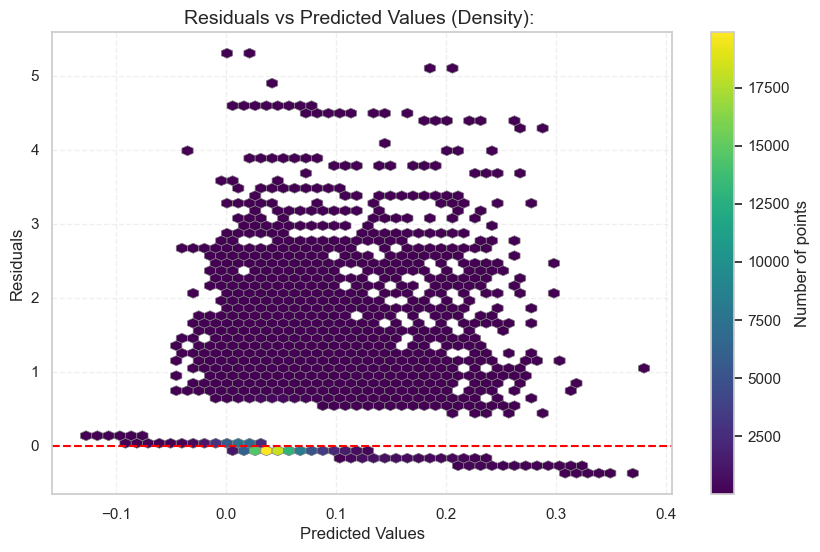

In [16]:
residual_plot(y_true=y_test, y_pred=y_test_pred)

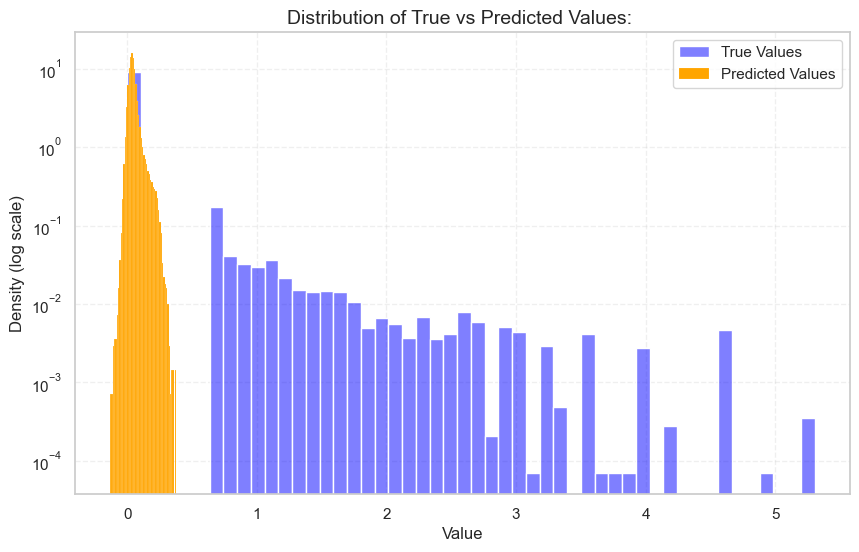

In [17]:
prediction_distribution(y_true=y_test, y_pred=y_test_pred)

d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


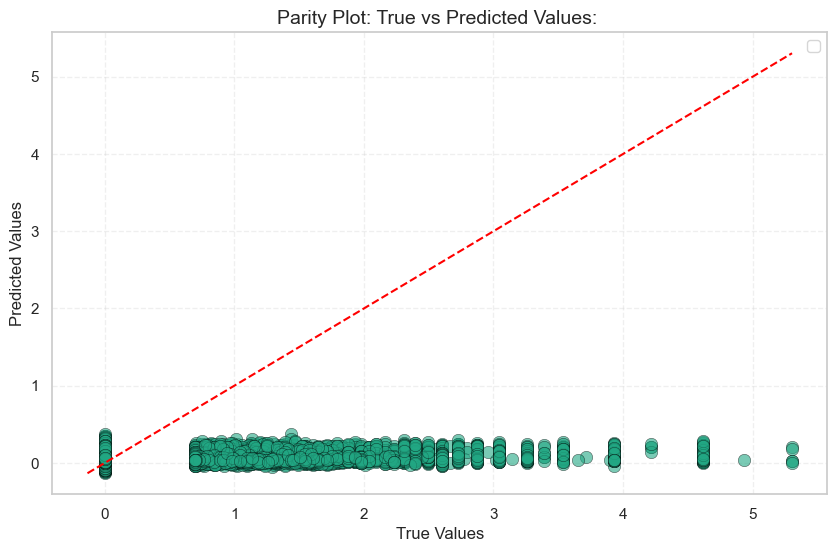

In [18]:
parity_plot(y_pred=y_test_pred, y_true=y_test)

### Saving the model

In [9]:
joblib.dump(best_model, "../models/best_mlp_scratch_model.joblib")

['../models/best_mlp_scratch_model.joblib']